In [1]:
#%matplotlib notebook
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Завантаження
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормалізація та розширення до 3 каналів
x_train = np.stack([x_train] * 3, axis=-1) / 255.0
x_test = np.stack([x_test] * 3, axis=-1) / 255.0

# Масштабування зображень до 224x224 (для VGG16)
x_train = np.array([resize(img, (32, 32)) for img in x_train])
x_test = np.array([resize(img, (32, 32)) for img in x_test])

# one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


In [3]:
image_input = tf.keras.layers.Input(shape=(32,32, 3)) 
baseModel_VGG_16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=image_input) 

for layer in baseModel_VGG_16.layers:
    layer.trainable = False

baseModel_VGG_16.summary()  

for layer in baseModel_VGG_16.layers:
    layer.trainable = True

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [4]:
model_final = Sequential([
    baseModel_VGG_16,
    Flatten(),
    Dense(units=1000, activation='relu'),
    Dense(units=800, activation='relu'),
    Dense(units=400, activation='relu'),
    Dense(units=200, activation='relu'),
    Dense(units=100, activation='relu'),
    Dense(units=10, activation='softmax')
])

model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dense_1 (Dense)             (None, 800)               800800    
                                                                 
 dense_2 (Dense)             (None, 400)               320400    
                                                                 
 dense_3 (Dense)             (None, 200)               80200     
                                                                 
 dense_4 (Dense)             (None, 100)               2

In [5]:
base_learning_rate = 0.0001  
optimizer = Adam(learning_rate=base_learning_rate, clipvalue=1.0)
model_final.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# training the Model with call back along with test and training data on a batch size of 128
history = model_final.fit(np.asarray(x_train),
                          np.asarray(y_train),
                          validation_split=0.1,
                          epochs=5,
                          batch_size=32) 


Epoch 1/5
1688/1688 [==============================] - 1082s 640ms/step - loss: 0.4040 - accuracy: 0.8568 - val_loss: 0.3044 - val_accuracy: 0.8908
Epoch 2/5
1688/1688 [==============================] - 1087s 644ms/step - loss: 0.2559 - accuracy: 0.9097 - val_loss: 0.2442 - val_accuracy: 0.9145
Epoch 3/5
1688/1688 [==============================] - 1088s 644ms/step - loss: 0.2150 - accuracy: 0.9242 - val_loss: 0.2146 - val_accuracy: 0.9225
Epoch 4/5
1688/1688 [==============================] - 1088s 645ms/step - loss: 0.1846 - accuracy: 0.9356 - val_loss: 0.2065 - val_accuracy: 0.9298
Epoch 5/5
1688/1688 [==============================] - 1107s 656ms/step - loss: 0.1659 - accuracy: 0.9421 - val_loss: 0.1945 - val_accuracy: 0.9332


In [9]:
import json
# Сохранение истории в файл
with open('vgg16_history.json', 'w') as f:
    json.dump(history.history, f)

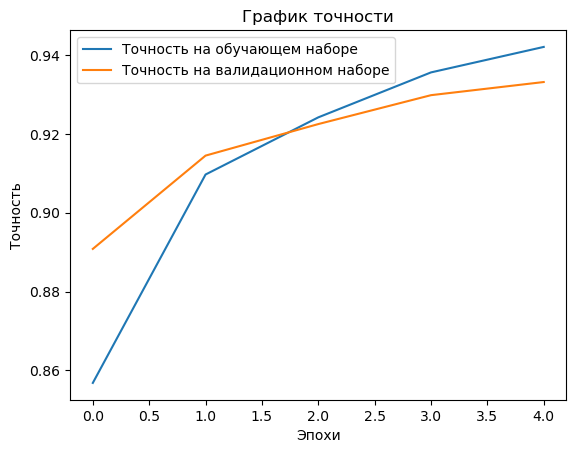

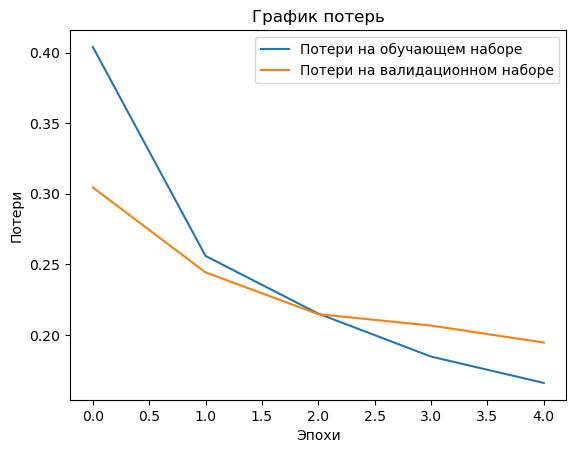

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import json

with open('vgg16_history.json', 'r') as f:
    history_data = json.load(f)

# Построение графика точности
plt.plot(history_data['accuracy'], label='Точность на обучающем наборе')
plt.plot(history_data['val_accuracy'], label='Точность на валидационном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.title('График точности')
plt.show()

# Построение графика потерь
plt.plot(history_data['loss'], label='Потери на обучающем наборе')
plt.plot(history_data['val_loss'], label='Потери на валидационном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.title('График потерь')
plt.show()

In [9]:
model_final.save('fashion_mnist_fine_tuned_vgg16.h5')
model_final.save_weights('fashion_mnist_fine_tuned_vgg16_weights.h5')

In [ ]:
Висновки:
VGG16 - складніша модель, дає дуже хороші результати, але навчання займає багато часу, і вона може бути перевантаженою для простих задач.
Згорткова модель -  швидше навчається і дає схожі результати, але з меншою складністю. 
Вона може бути хорошим варіантом для задач, де важлива швидкість і ефективність, але при цьому не дуже важлива точність, яка може просідати.